<a href="https://colab.research.google.com/github/PradHolla/Crop-Disease-Detection/blob/master/training/Tomato_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Tomato",
    shuffle=True,
    image_size =(IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 4500 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_healthy']

In [5]:
len(dataset)

141

In [ ]:
68*32

2176

(32, 256, 256, 3)
[1 1 1 1 2 2 1 1 1 1 2 1 1 2 2 1 1 1 1 2 2 1 1 1 1 2 0 1 2 0 0 1]


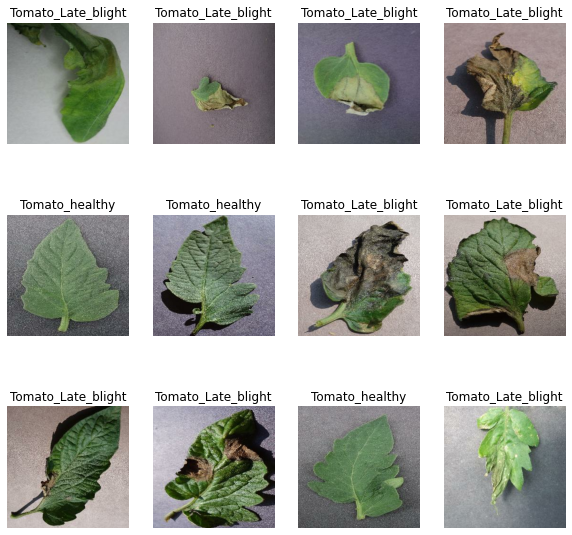

In [7]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

    print(image_batch.shape)
    print(label_batch.numpy())

In [12]:
len(dataset)

141

In [ ]:
80% ==> training
20% ==> 10% validation, 10% test

SyntaxError: invalid syntax (Temp/ipykernel_5796/829920516.py, line 1)

In [8]:
train_size = 0.8
len(dataset)*train_size


112.80000000000001

In [6]:
train_ds = dataset.take(113)
len(train_ds)

113

In [7]:
test_ds = dataset.skip(113) 
len(test_ds)

28

In [13]:
val_size = 0.1
len(dataset)*val_size

14.100000000000001

In [8]:
val_ds = test_ds.take(10)
len(val_ds)

10

In [9]:
test_ds = test_ds.skip(10)
len(test_ds)

18

In [10]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [11]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [12]:
len(train_ds)

112

In [13]:
len(val_ds)

14

In [14]:
len(test_ds)

15

In [15]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [16]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [17]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [18]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [19]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 128)       36992     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 128)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 128)        

In [20]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [21]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=2,
    epochs=50,
)

Epoch 1/50
112/112 - 301s - loss: 1.4910 - accuracy: 0.5988 - val_loss: 0.5030 - val_accuracy: 0.7969 - 301s/epoch - 3s/step
Epoch 2/50
112/112 - 21s - loss: 0.4855 - accuracy: 0.7951 - val_loss: 0.4236 - val_accuracy: 0.8348 - 21s/epoch - 188ms/step
Epoch 3/50
112/112 - 21s - loss: 0.3976 - accuracy: 0.8418 - val_loss: 0.7277 - val_accuracy: 0.7009 - 21s/epoch - 187ms/step
Epoch 4/50
112/112 - 21s - loss: 0.4592 - accuracy: 0.8147 - val_loss: 0.2549 - val_accuracy: 0.8906 - 21s/epoch - 187ms/step
Epoch 5/50
112/112 - 21s - loss: 0.2619 - accuracy: 0.8967 - val_loss: 0.2826 - val_accuracy: 0.8839 - 21s/epoch - 188ms/step
Epoch 6/50
112/112 - 21s - loss: 0.2075 - accuracy: 0.9197 - val_loss: 0.2277 - val_accuracy: 0.9062 - 21s/epoch - 187ms/step
Epoch 7/50
112/112 - 21s - loss: 0.1959 - accuracy: 0.9233 - val_loss: 0.1946 - val_accuracy: 0.9286 - 21s/epoch - 187ms/step
Epoch 8/50
112/112 - 21s - loss: 0.2188 - accuracy: 0.9269 - val_loss: 0.2714 - val_accuracy: 0.8973 - 21s/epoch - 188m

In [24]:
scores = model.evaluate(test_ds)

15/15 [==============================] - 13s 78ms/step - loss: 0.0434 - accuracy: 0.9937


In [25]:
scores

[0.04340333491563797, 0.9937499761581421]

In [ ]:
history

In [ ]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
type(history.history['loss'])

list

In [ ]:
len(history.history['loss'])

50

In [ ]:
history.history['loss'][:5]

[2.0808749198913574,
 0.6810778975486755,
 0.45522573590278625,
 0.4840245842933655,
 0.26640748977661133]

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

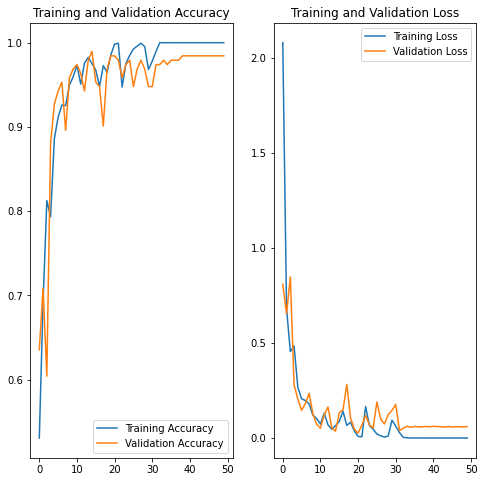

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Early_blight
predicted label: Potato___Early_blight


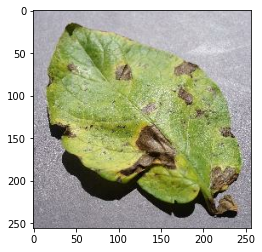

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

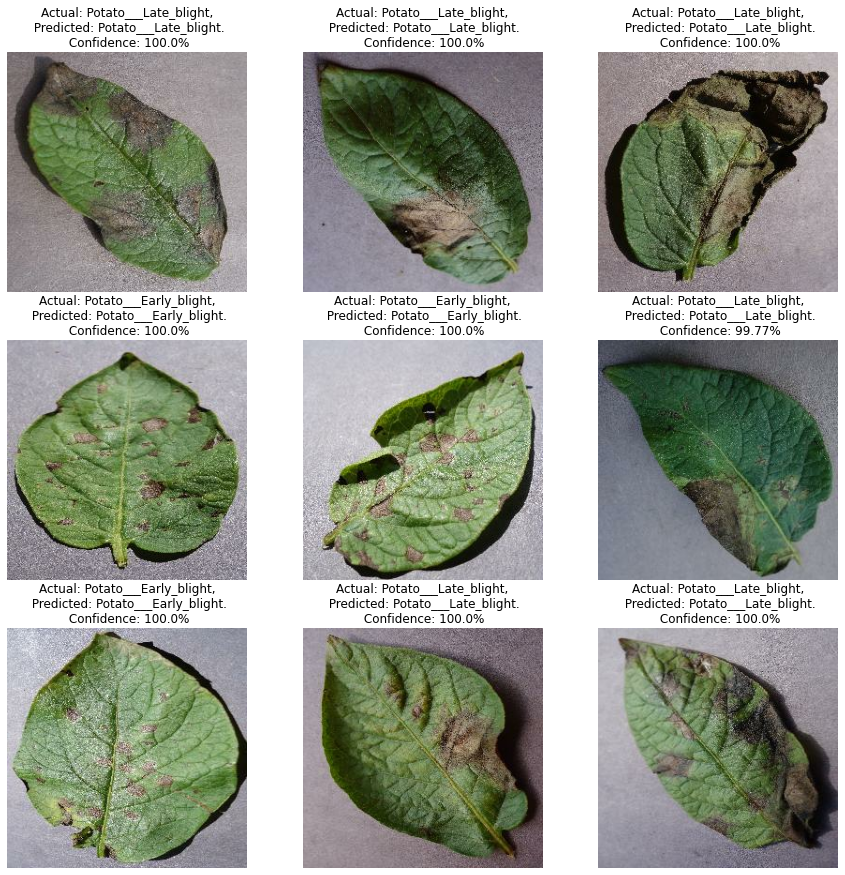

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [ ]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/2\assets


In [22]:
model.save("tomatoes.h5")

In [23]:
model.save("/content/drive/MyDrive/tomatoess.h5")